In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def display_image(title, image, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

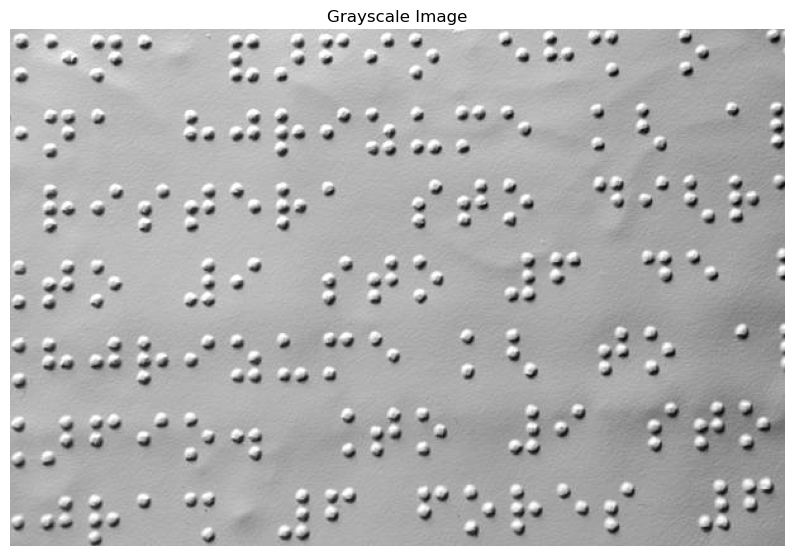

In [16]:
# Step 1: Import and Preprocess the Image
img = cv2.imread('./raw_dataset/img9.jpg')
if img is None:
    raise FileNotFoundError(f"Image not found at {'./raw_dataset/img4.jpg'}")
image = img.copy()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

display_image("Grayscale Image", gray)

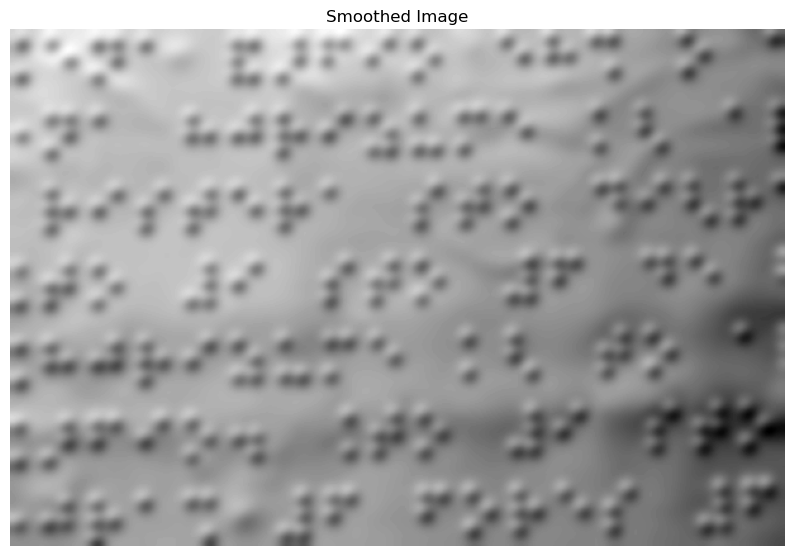

In [17]:
# Noise Reduction
smoothed = cv2.GaussianBlur(gray, (29, 29), 0)
display_image("Smoothed Image", smoothed)

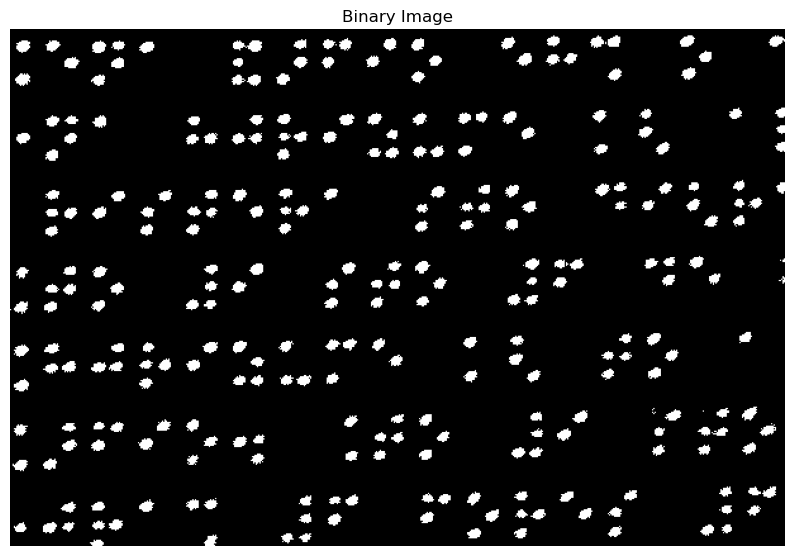

In [18]:
# Step 3: Segment the Braille Characters
binary = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
display_image("Binary Image", binary)

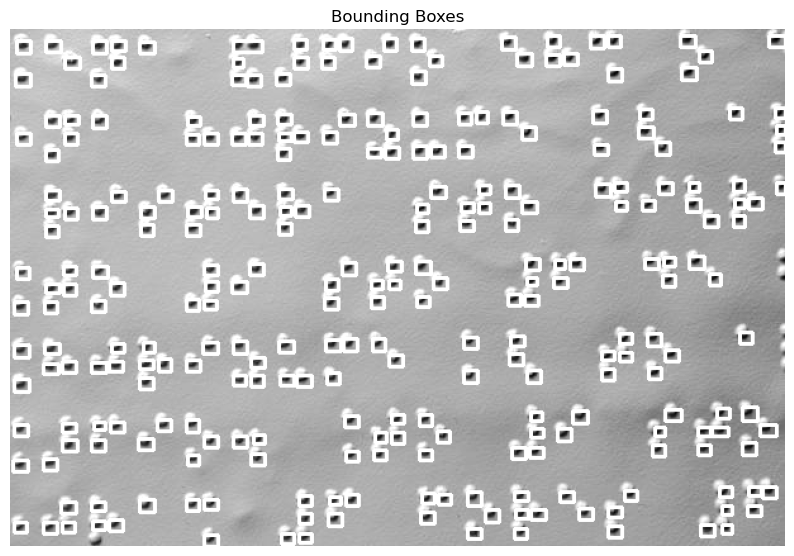

In [19]:
dot_contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter and Display Contours
output = gray.copy()
min_width, min_height = 5, 5  # Adjust based on Braille dot size
cropped_images = []

for contour in dot_contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > min_width and h > min_height:
        cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cropped = gray[y:y + h, x:x + w]
        cropped_images.append(cropped)

# Display the image with bounding boxes
display_image("Bounding Boxes", output)

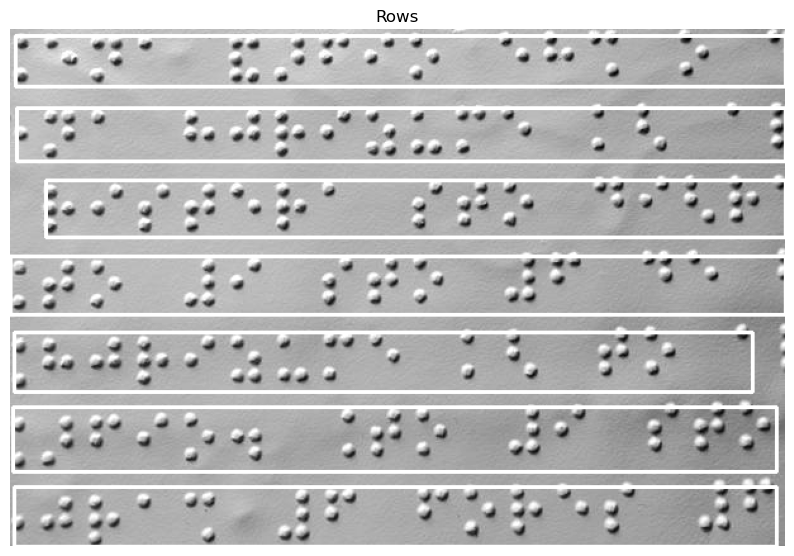

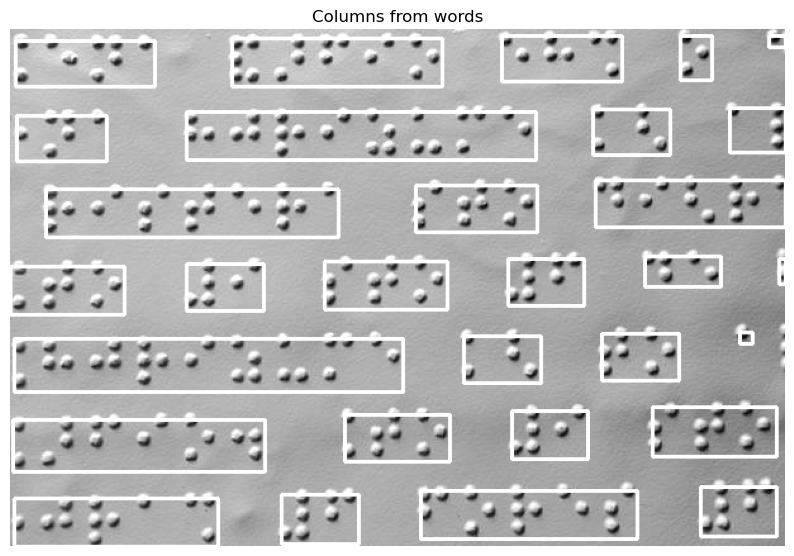

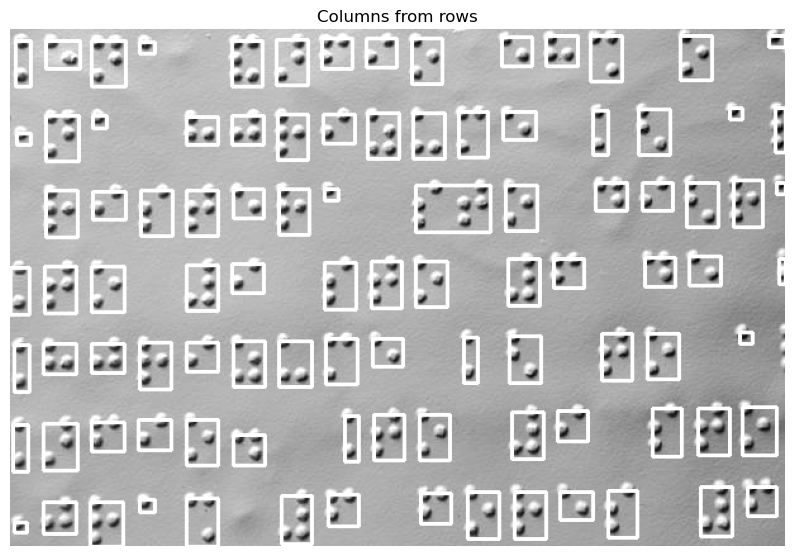

In [23]:
import numpy as np

# Parameters (adjust based on Braille dot size and spacing)
# We will start with 20*20 but we will make it dynamic later
dot_spacing_threshold = 20  # Distance threshold to group dots into a row
letter_spacing_threshold = 20  # Distance threshold to group rows into letters
word_spacing_threshold = 40  # Distance threshold to group rows into words

# Sort contours by y, then x
dot_contours = sorted(dot_contours, key=lambda cnt: (cv2.boundingRect(cnt)[1], cv2.boundingRect(cnt)[0]))

# Group dots into rows
rows = []
current_row = []
previous_y = None

for contour in dot_contours:
    x, y, w, h = cv2.boundingRect(contour)
    center_y = y + h // 2

    if previous_y is None or abs(center_y - previous_y) < dot_spacing_threshold:
        current_row.append((x, y, w, h))
    else:
        rows.append(current_row)
        current_row = [(x, y, w, h)]
    previous_y = center_y

if current_row:
    rows.append(current_row)
    
# Display the extracted letters
output2 = gray.copy()
for row in rows:
    min_x = min([x for x, y, w, h in row])
    min_y = min([y for x, y, w, h in row])
    max_x = max([x + w for x, y, w, h in row])
    max_y = max([y + h for x, y, w, h in row])
    cv2.rectangle(output2, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
display_image("Rows", output2)


# Group rows into words
words = []
for row in rows:
    row = sorted(row, key=lambda b: b[0])  # Sort by x-coordinate
    current_word = []
    prev_x = None

    for bbox in row:
        x, y, w, h = bbox
        center_x = x + w // 2

        if prev_x is None or abs(center_x - prev_x) < word_spacing_threshold:
            current_word.append(bbox)
        else:
            words.append(current_word)
            current_word = [bbox]
        prev_x = center_x

    if current_word:
        words.append(current_word)
        
        
output_words = gray.copy()
for word in words:
    min_x = min([x for x, y, w, h in word])
    min_y = min([y for x, y, w, h in word])
    max_x = max([x + w for x, y, w, h in word])
    max_y = max([y + h for x, y, w, h in word])
    cv2.rectangle(output_words, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
display_image("Columns from words", output_words)


# Group rows into letters
letters = []
for row in rows:
    row = sorted(row, key=lambda b: b[0])  # Sort by x-coordinate
    current_letter = []
    previous_x = None

    for bbox in row:
        x, y, w, h = bbox
        center_x = x + w // 2

        if previous_x is None or abs(center_x - previous_x) < letter_spacing_threshold:
            current_letter.append(bbox)
        else:
            letters.append(current_letter)
            current_letter = [bbox]
        previous_x = center_x

    if current_letter:
        letters.append(current_letter)
        
        
output3 = gray.copy()
for letter in letters:
    min_x = min([x for x, y, w, h in letter])
    min_y = min([y for x, y, w, h in letter])
    max_x = max([x + w for x, y, w, h in letter])
    max_y = max([y + h for x, y, w, h in letter])
    cv2.rectangle(output3, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
display_image("Columns from rows", output3)


In [27]:
def normalize_to_grid(letter_bboxes, grid_size=(3, 2)):
    min_x = min(bbox[0] for bbox in letter_bboxes)
    min_y = min(bbox[1] for bbox in letter_bboxes)
    max_x = max(bbox[0] + bbox[2] for bbox in letter_bboxes)
    max_y = max(bbox[1] + bbox[3] for bbox in letter_bboxes)
    
    width = max_x - min_x
    height = max_y - min_y
    
    grid = np.zeros(grid_size, dtype=int)
    
    for x, y, w, h in letter_bboxes:
        col = int(grid_size[1] * (x - min_x) / width) # 2 * ( 4 - 4 ) / 12 = 0   ->  2 * ( 5 - 4 ) / 12 = 0
        row = int(grid_size[0] * (y - min_y) / height) # 3 * ( 35 - 9 ) / 36 = 2   ->  3 * ( 9 - 9 ) / 36 = 0 
        grid[row, col] = 1
    
    return grid


In [29]:
braille_dict = {
    'a': np.array([[1, 0], [0, 0], [0, 0]]),
    'b': np.array([[1, 0], [1, 0], [0, 0]]),
    'c': np.array([[1, 1], [0, 0], [0, 0]]),
    'd': np.array([[1, 1], [0, 1], [0, 0]]),
    'e': np.array([[1, 0], [0, 1], [0, 0]]),
    'f': np.array([[1, 1], [1, 0], [0, 0]]),
    'g': np.array([[1, 1], [1, 1], [0, 0]]),
    'h': np.array([[1, 0], [1, 1], [0, 0]]),
    'i': np.array([[0, 1], [1, 0], [0, 0]]),
    'j': np.array([[0, 1], [1, 1], [0, 0]]),
    'k': np.array([[1, 0], [0, 0], [1, 0]]),
    'l': np.array([[1, 0], [1, 0], [1, 0]]),
    'm': np.array([[1, 1], [0, 0], [1, 0]]),
    'n': np.array([[1, 1], [0, 1], [1, 0]]),
    'o': np.array([[1, 0], [0, 1], [1, 0]]),
    'p': np.array([[1, 1], [1, 0], [1, 0]]),
    'q': np.array([[1, 1], [1, 1], [1, 0]]),
    'r': np.array([[1, 0], [1, 1], [1, 0]]),
    's': np.array([[0, 1], [1, 0], [1, 0]]),
    't': np.array([[0, 1], [1, 1], [1, 0]]),
    'u': np.array([[1, 0], [0, 0], [1, 1]]),
    'v': np.array([[1, 0], [1, 0], [1, 1]]),
    'w': np.array([[0, 1], [1, 1], [0, 1]]),
    'x': np.array([[1, 1], [0, 0], [1, 1]]),
    'y': np.array([[1, 1], [0, 1], [1, 1]]),
    'z': np.array([[1, 0], [0, 1], [1, 1]])
}



for letter in letters:
    normalized = normalize_to_grid(letter)
    for char, pattern in braille_dict.items():
        if np.array_equal(normalized, pattern):
            print(char, end="")

kenavfioehoaanahjrizumekalristeraoiraktoistoyfdemkojrizumektoakfiodktoilpoajrafforesf